In [38]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os

def import_from_excel(e_file, filename):
    kinase_targets = e_file['kinase target'].tolist()
    JS_scores = e_file['JS Distance Score'].tolist()
    off_targets = e_file['off-target %inhibition values'].tolist()
    mu = int(filename.split('.')[0].split('_')[-1])
    return [mu, kinase_targets, JS_scores, off_targets]

test_results_200 = []
test_results_700 = []

for filename in os.listdir(os.getcwd()+'/results_PKIS2/'):
    f = './results_PKIS2/'+str(filename)
    if filename[0] != '.' and f[0] != '~':
        replicate_results = []
        for x in range(1,4):
            open_file = pd.read_excel(f, str(x))
            inhibitor_combination = import_from_excel(open_file, filename)
            replicate_results.append((x,inhibitor_combination))
        if replicate_results[0][1][0] == 200:
            test_results_200.append(replicate_results)
        elif replicate_results[0][1][0] == 1200:
            test_results_700.append(replicate_results)
        
PKIS2_data=pd.read_excel("./PKIS2_dataset_EPHS.xlsx")
all_kinase_names = list(PKIS2_data.columns.values)[7:]
        
#check to make sure we have 5 sets of results for each       
print(len(test_results_200))
print(len(test_results_700))

5
5


/usr/local/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


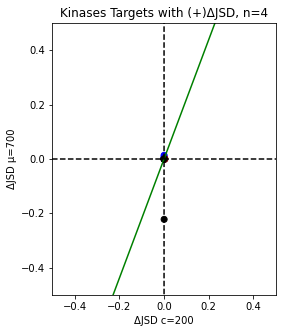

In [62]:
# Same as above but set a threshold for changes that are more relevant versus less relevant
# Count the number of kinases that fall over this threshold

#check to see what the maximum inhibitor concentration # is that we should use
max_inhib_num = len(test_results_200[0])

#for each kinase, get the set of scores at i=1, i=2, i=3 etc

organized_results_200 = {}
organized_results_700 = {}

off_target_values_200 = {}
off_target_values_700 = {}

for replicate_200 in test_results_200:    #in each of the 5 test replicates
    for individual_result in replicate_200:    #for each combination
        inhibitor_combination_number = individual_result[0]     
        k_names = individual_result[1][1]
        JS_scores = individual_result[1][2]
        off_target_values = individual_result[1][3]
        for i in range(0, len(k_names)):
            if k_names[i] not in organized_results_200:
                organized_results_200[k_names[i]] = [[] for x in range(0,max_inhib_num)]
                off_target_values_200[k_names[i]] = [[] for x in range(0,max_inhib_num)]
            organized_results_200[k_names[i]][inhibitor_combination_number-1].append(JS_scores[i])
            off_target_values_200[k_names[i]][inhibitor_combination_number-1].append(off_target_values[i])
            
for replicate_700 in test_results_700:    #in each of the 5 test replicates
    for individual_result in replicate_700:    #for each combination
        inhibitor_combination_number = individual_result[0]     
        k_names = individual_result[1][1]
        JS_scores = individual_result[1][2]
        off_target_values = individual_result[1][3]
        for i in range(0, len(k_names)):
            if k_names[i] not in organized_results_700:
                organized_results_700[k_names[i]] = [[] for x in range(0,max_inhib_num)]
                off_target_values_700[k_names[i]] = [[] for x in range(0,max_inhib_num)]
            organized_results_700[k_names[i]][inhibitor_combination_number-1].append(JS_scores[i])
            off_target_values_700[k_names[i]][inhibitor_combination_number-1].append(off_target_values[i])

#determine which condition has the maximum mean score, what the difference is from the i=1 mean score, 
#and if that difference is significant or not

x_200_scored_kinase_names = []
x_200_values = []
x_sig = []
max_200_vals = []
stdevs_200 = [] #the std of the differences from i=1 to i>1 if i>1 is greater
JSD_200_i1_scores = [] #the raw scores
JSD_200_max_scores = [] #the raw scores
off_target_values_u200 = []
off_target_values_i1_u200 = []

y_700_scored_kinase_names = []
y_700_values = []
y_sig = []
max_700_vals = []
stdevs_700 = [] #the std of the differences from i=1 to i>1 if i>1 is greater
JSD_700_i1_scores = [] #the raw scores
JSD_700_max_scores = [] #the raw scores
off_target_values_u700 = []
off_target_values_i1_u700 = []

for kinase in organized_results_200:
    #get the i=1 conition
    i1_mean = np.mean(organized_results_200[kinase][0])
    i1_values = organized_results_200[kinase][0]
    max_other_combination = 0
    max_other_combination_values = []
    significant = 0
    best_combination_number = None
    #compare to higher combination #s
    for j in range(1, max_inhib_num):
        if organized_results_200[kinase][j] != []:
            i_combo_mean = np.mean(organized_results_200[kinase][j])
            if i_combo_mean > max_other_combination:
                max_other_combination = i_combo_mean
                max_other_combination_values = organized_results_200[kinase][j]
                best_combination_number = j+1
    if max_other_combination_values != []:
        max_200_vals.append(max_other_combination)
        differences = [max_other_combination_values[x] - i1_values[x] for x in range(0,len(i1_values))]
        stdev = np.std(differences)
        stdevs_200.append(stdev)
        #is the difference significant?
        tval, pval = stats.ttest_ind(i1_values, max_other_combination_values)
        if (pval < 0.05) and (np.mean(max_other_combination_values) > (i1_mean + 0.001)):
            significant = 1
        JS_score_difference = max_other_combination - i1_mean
        x_200_scored_kinase_names.append(kinase)
        x_200_values.append(JS_score_difference)
        x_sig.append(significant)
        JSD_200_i1_scores.append(i1_values)
        JSD_200_max_scores.append(max_other_combination_values)
        off_target_values_u200.append(off_target_values_200[kinase][best_combination_number-1]) #due to 0 indexing
        off_target_values_i1_u200.append(off_target_values_200[kinase][0])
    
for kinase in organized_results_700:
    #get the i=1 conition
    i1_mean = np.mean(organized_results_700[kinase][0])
    i1_values = organized_results_700[kinase][0]
    max_other_combination = 0
    max_other_combination_values = []
    significant = 0
    best_combination_number = None
    #compare to higher combination #s
    for j in range(1, max_inhib_num):
        if organized_results_700[kinase][j] != []:
            i_combo_mean = np.mean(organized_results_700[kinase][j])
            if i_combo_mean > max_other_combination:
                max_other_combination = i_combo_mean
                max_other_combination_values = organized_results_700[kinase][j]
                best_combination_number = j+1
    if max_other_combination_values != []:
        max_700_vals.append(max_other_combination)
        differences = [max_other_combination_values[x] - i1_values[x] for x in range(0,len(i1_values))]
        stdev = np.std(differences)
        stdevs_700.append(stdev)
        #is the difference significant?
        tval, pval = stats.ttest_ind(i1_values, max_other_combination_values)
        if (pval < 0.05) and (np.mean(max_other_combination_values) > (i1_mean + 0.001)):
            significant = 2
        JS_score_difference = max_other_combination - i1_mean
        y_700_scored_kinase_names.append(kinase)
        y_700_values.append(JS_score_difference)
        y_sig.append(significant)
        JSD_700_i1_scores.append(i1_values)
        JSD_700_max_scores.append(max_other_combination_values)
        off_target_values_u700.append(off_target_values_700[kinase][best_combination_number-1]) #due to 0 indexing
        off_target_values_i1_u700.append(off_target_values_700[kinase][0])
        
#for each kinase in PKIS2, get the x_val, the y_val, the total significance

final_kinases = []
final_x = []
final_y = []
sum_sig = []

final_std_200 = []
final_std_700 = []

final_JSD_200_i1 = []
final_JSD_700_i1 = []
final_JSD_200_max = []
final_JSD_700_max = []

final_JSD_200_i1_stdev = []
final_JSD_700_i1_stdev = []
final_JSD_200_max_stdev = []
final_JSD_700_max_stdev = []

final_200_off_target_values = []
final_700_off_target_values = []

final_i1_200_off_target_values = []
final_i1_700_off_target_values = []

for kinase_target in all_kinase_names:
    #final_kinases.append(kinase_target)
    
    add = False
    x_index = None
    y_index = None
    
    if kinase_target in x_200_scored_kinase_names:
        x_index = x_200_scored_kinase_names.index(kinase_target)
        #final_x.append(x_200_values[x_index])
        if x_sig[x_index] > 0:
            add=True
        #sum_sig.append(x_sig[index])
    #else:
        #final_x.append(0)
        #sum_sig.append(0)
    if kinase_target in y_700_scored_kinase_names:
        y_index = y_700_scored_kinase_names.index(kinase_target)
        if y_sig[y_index] > 0:
            add = True
        #final_y.append(y_700_values[index])
        #sum_sig[-1] = sum_sig[-1] + y_sig[index]
    #else:
        #final_y.append(0)
    add = True
    
    if add:
        final_x.append(x_200_values[x_index])
        final_y.append(y_700_values[y_index])
        sum_sig.append(x_sig[x_index]+y_sig[y_index])
        final_kinases.append(kinase_target)
        final_std_700.append(stdevs_700[y_index]) # the std of the differences in score
        final_std_200.append(stdevs_200[x_index]) #the std off the differences in score
        
        final_JSD_200_i1.append(np.mean(JSD_200_i1_scores[x_index]))
        final_JSD_200_max.append(np.mean(JSD_200_max_scores[x_index]))
        final_JSD_200_i1_stdev.append(np.std(JSD_200_i1_scores[x_index]))
        final_JSD_200_max_stdev.append(np.std(JSD_200_max_scores[x_index]))
        
        final_JSD_700_i1.append(np.mean(JSD_700_i1_scores[y_index]))
        final_JSD_700_max.append(np.mean(JSD_700_max_scores[y_index]))
        final_JSD_700_i1_stdev.append(np.std(JSD_700_i1_scores[y_index]))
        final_JSD_700_max_stdev.append(np.std(JSD_700_max_scores[y_index]))
        
        final_200_off_target_values.append(off_target_values_u200[x_index])
        final_700_off_target_values.append(off_target_values_u700[y_index])
        
        final_i1_200_off_target_values.append(off_target_values_i1_u200[x_index])
        final_i1_700_off_target_values.append(off_target_values_i1_u700[y_index])
        
#convert significane to a different color for the points
#black = not significant
#yellow = significant for 200 (1)
#blue = significant for 700 (2)
#cyan = significant for both (3)
point_color = []
total = 0
for value in sum_sig:
    if value == 1:
        point_color.append('darkred')
        total+=1
    elif value == 2:
        point_color.append('b')
        total+=1
    elif value == 3:
        point_color.append('darkorange')
        total+=1
    else:
        point_color.append('k')
       
fig = plt.figure(figsize=(4, 5))
plt.scatter(final_x, final_y, c=point_color)
#total = 0
#for i, label in enumerate(final_kinases):
    #if final_x[i] > 0.025 or final_y[i] > (0.025*1.8): 
        #plt.annotate(label, (final_x[i], final_y[i]))
#    if final_x[i] > 0 or final_y[i] >0:
#        total += 1
plt.xlim((-0.5,0.5))
plt.ylim((-0.5,0.5))
plt.xlabel('ΔJSD c=200')
plt.ylabel('ΔJSD μ=700')
title = 'Kinases Targets with (+)ΔJSD, n=' + str(total)
plt.title(title)

#finally, add a line that represents an equal improvement to the maximum of 1 in both scales
#the 1 - average max(JSD at i=1) at mu=700 / 1 - average max(JSD at i=1) at mu=200, gives the slope
#essentially, its a scaled measure of how much improvement in the score is possible relative to a maximum of 1.
#note - since it represents the average change, it is possible for some points to represent statistically significant change on one axis but NOT the other

mu700 = [] #the i=1 scores
mu200 = [] #the i=1 scores
for kinase in organized_results_700:
    mu700.append(np.mean(organized_results_700[kinase][0]))
for kinase in organized_results_200:
    mu200.append(np.mean(organized_results_200[kinase][0]))
slope = (1 - np.mean(mu700)) / (1 - np.mean(mu200))
xv = np.arange(-1,1,0.001)
yv = xv*slope

zeros = xv*0

plt.plot(xv,yv,color='g')

plt.plot(xv,zeros,'k--')
plt.plot(zeros,yv,'k--')

plt.show()

#fig.savefig("120121_PKIS2_JSD_700v200_scatterplot.pdf", bbox_inches='tight',dpi=500)

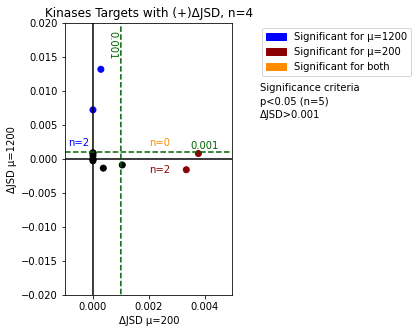

In [79]:
#replot with tighter axis
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(3, 5))

mu700 = [] #the i=1 scores
mu200 = [] #the i=1 scores
for kinase in organized_results_700:
    mu700.append(np.mean(organized_results_700[kinase][0]))
for kinase in organized_results_200:
    mu200.append(np.mean(organized_results_200[kinase][0]))
slope = (1 - np.mean(mu700)) / (1 - np.mean(mu200))
xv = np.arange(-1,1,0.001)
yv = xv*slope

zeros = xv*0

#plt.plot(xv,yv,color='g')

plt.plot(xv,zeros,'k-')
plt.plot(zeros,yv,'k-')

threshlimit = np.arange(-1,1,0.0001)
tlim = [0.001]*len(threshlimit)

plt.plot(threshlimit,tlim,'--',color='darkgreen')
plt.plot(tlim,threshlimit,'--',color='darkgreen')

plt.scatter(final_x, final_y, c=point_color)
#total = 0
#for i, label in enumerate(final_kinases):
    #if final_x[i] > 0.025 or final_y[i] > (0.025*1.8): 
    #plt.annotate(label, (final_x[i], final_y[i]))
#    if final_x[i] > 0 or final_y[i] >0:
#        total += 1
plt.xlim((-0.001,0.005))
plt.ylim((-0.02,0.02))
plt.xlabel('ΔJSD μ=200')
plt.ylabel('ΔJSD μ=1200')
title = 'Kinases Targets with (+)ΔJSD, n=' + str(total)
plt.title(title)

#finally, add a line that represents an equal improvement to the maximum of 1 in both scales
#the 1 - average max(JSD at i=1) at mu=700 / 1 - average max(JSD at i=1) at mu=200, gives the slope
#essentially, its a scaled measure of how much improvement in the score is possible relative to a maximum of 1.
#note - since it represents the average change, it is possible for some points to represent statistically significant change on one axis but NOT the other
u700ldg = mpatches.Patch(color='b', label='Significant for μ=1200')
u200ldg = mpatches.Patch(color='darkred', label='Significant for μ=200')
bothldg = mpatches.Patch(color='darkorange', label='Significant for both')

fig.legend(handles=[u700ldg, u200ldg, bothldg],bbox_to_anchor=(1.75, 0.88))

plt.text(0.0035,0.0015,'0.001', color='darkgreen')
plt.text(0.0005,0.015,'0.001', color='darkgreen',rotation=-90)

plt.text(-0.0009,0.002,'n=2', color='b')
plt.text(0.002,-0.002,'n=2', color='darkred')
plt.text(0.002,0.002,'n=0', color='darkorange')

plt.text(0.006,0.01,'Significance criteria')
plt.text(0.006,0.008,'p<0.05 (n=5)')
plt.text(0.006,0.006,'ΔJSD>0.001')

plt.show()

fig.savefig("120821_PKIS2_EPHS_JSD_200v1200_scatterplot_4sig_zoomin.pdf", bbox_inches='tight',dpi=500)

2 2 0
kinase ΔJSD_μ=200 ΔJSD_μ=1200


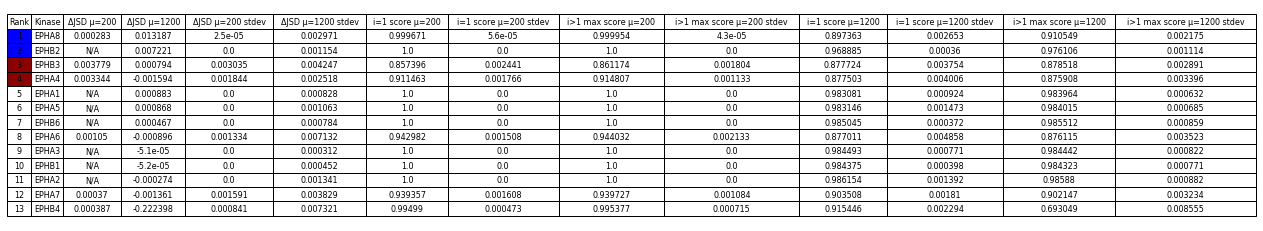

In [76]:
#Who are the kinases that showed statistically significant improvement?

n700 = 0
n200 = 0
both = 0

res = []
for i in range(0, len(final_kinases)):
    k = final_kinases[i]
    mu200 = final_x[i]
    mu700 = final_y[i]
    tscore = mu200+mu700
    std200 = final_std_200[i]
    std700 = final_std_700[i]
    #original scores
    i1_200_score = final_JSD_200_i1[i]
    max_200_score = final_JSD_200_max[i]
    i1_200_score_stdev = final_JSD_200_i1_stdev[i]
    max_200_score_stdev = final_JSD_200_max_stdev[i]
    i1_700_score = final_JSD_700_i1[i]
    max_700_score = final_JSD_700_max[i]
    i1_700_score_stdev = final_JSD_700_i1_stdev[i]
    max_700_score_stdev = final_JSD_700_max_stdev[i]
    if mu200 == 0:
        mu200 = 'N/A'
    if mu700 == 0:
        mu700 = 'N/A'
    sig = sum_sig[i]
    if sig>=0:
        scolor = 'w'
        if sig == 1:
            n200 += 1
            scolor = 'darkred'
        if sig == 2:
            n700 += 1
            scolor = 'b'
        if sig == 3:
            both += 1
            scolor = 'darkorange'
        res.append([tscore,k,mu200,mu700,std200,std700,
                    i1_200_score,i1_200_score_stdev,max_200_score,max_200_score_stdev,
                    i1_700_score,i1_700_score_stdev,max_700_score,max_700_score_stdev,scolor])
            
tabled = []
cell_color = []
tabled.append(['Rank','Kinase','ΔJSD μ=200','ΔJSD μ=1200','ΔJSD μ=200 stdev', 'ΔJSD μ=1200 stdev',
               'i=1 score μ=200','i=1 score μ=200 stdev','i>1 max score μ=200','i>1 max score μ=200 stdev',
               'i=1 score μ=1200','i=1 score μ=1200 stdev','i>1 max score μ=1200','i>1 max score μ=1200 stdev'])
cell_color.append(['w','w','w','w','w','w','w','w','w','w','w','w','w','w'])
            
#print('average 200 i=1 score:' + str(np.mean(mu200)))
#print('average 700 i=1 score:' + str(np.mean(mu700)))
print(n700,n200,both)
res = sorted(res, key=lambda x: x[0], reverse=True)
print('kinase','ΔJSD_μ=200','ΔJSD_μ=1200')
counter = 1
for k in res:
    for j in range(2,14):
        if k[j] != 'N/A':
            temp = round(k[j],6)
            k[j] = temp
    tabled.append([counter,k[1],k[2],k[3],k[4],k[5],
                  k[6], k[7], k[8], k[9],
                  k[10], k[11], k[12], k[13]])
    #if k[2] > 0.001 or k[3]>0.001:
    color_val = k[14]
    cell_color.append([color_val,'w','w','w','w','w','w','w','w','w','w','w','w','w'])
    #else:
    #cell_color.append(['w','w','w','w','w','w','w','w','w','w','w','w','w','w'])
    #print(counter,k[1],k[2],k[3])
    counter+=1
    
fig, ax = plt.subplots()
table = ax.table(cellText=tabled, loc='center',cellLoc='center',cellColours=cell_color)
table.auto_set_font_size(False)
table.auto_set_column_width(col=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
table.set_fontsize(8)
table.scale(1,1.2)
ax.axis('off')
plt.show()
fig.savefig("120821_PKIS2_EPHS_JSD_200v1200_4k_improvement_table.pdf", bbox_inches='tight',dpi=500)

2 2 0
kinase ΔJSD_μ=200 ΔJSD_μ=1200


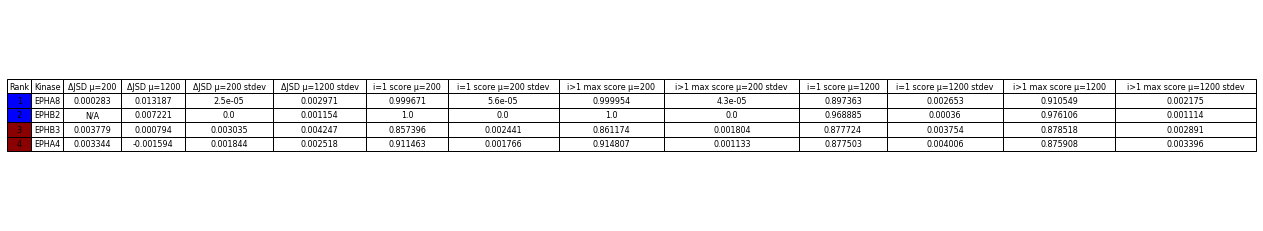

In [77]:
#same as above, but only for the significant ones

#Who are the kinases that showed statistically significant improvement?

n700 = 0
n200 = 0
both = 0

res = []
for i in range(0, len(final_kinases)):
    k = final_kinases[i]
    mu200 = final_x[i]
    mu700 = final_y[i]
    tscore = mu200+mu700
    std200 = final_std_200[i]
    std700 = final_std_700[i]
    #original scores
    i1_200_score = final_JSD_200_i1[i]
    max_200_score = final_JSD_200_max[i]
    i1_200_score_stdev = final_JSD_200_i1_stdev[i]
    max_200_score_stdev = final_JSD_200_max_stdev[i]
    i1_700_score = final_JSD_700_i1[i]
    max_700_score = final_JSD_700_max[i]
    i1_700_score_stdev = final_JSD_700_i1_stdev[i]
    max_700_score_stdev = final_JSD_700_max_stdev[i]
    if mu200 == 0:
        mu200 = 'N/A'
    if mu700 == 0:
        mu700 = 'N/A'
    sig = sum_sig[i]
    if sig>=1:
        scolor = 'w'
        if sig == 1:
            n200 += 1
            scolor = 'darkred'
        if sig == 2:
            n700 += 1
            scolor = 'b'
        if sig == 3:
            both += 1
            scolor = 'darkorange'
        res.append([tscore,k,mu200,mu700,std200,std700,
                    i1_200_score,i1_200_score_stdev,max_200_score,max_200_score_stdev,
                    i1_700_score,i1_700_score_stdev,max_700_score,max_700_score_stdev,scolor])
            
tabled = []
cell_color = []
tabled.append(['Rank','Kinase','ΔJSD μ=200','ΔJSD μ=1200','ΔJSD μ=200 stdev', 'ΔJSD μ=1200 stdev',
               'i=1 score μ=200','i=1 score μ=200 stdev','i>1 max score μ=200','i>1 max score μ=200 stdev',
               'i=1 score μ=1200','i=1 score μ=1200 stdev','i>1 max score μ=1200','i>1 max score μ=1200 stdev'])
cell_color.append(['w','w','w','w','w','w','w','w','w','w','w','w','w','w'])
            
#print('average 200 i=1 score:' + str(np.mean(mu200)))
#print('average 700 i=1 score:' + str(np.mean(mu700)))
print(n700,n200,both)
res = sorted(res, key=lambda x: x[0], reverse=True)
print('kinase','ΔJSD_μ=200','ΔJSD_μ=1200')
counter = 1
for k in res:
    for j in range(2,14):
        if k[j] != 'N/A':
            temp = round(k[j],6)
            k[j] = temp
    tabled.append([counter,k[1],k[2],k[3],k[4],k[5],
                  k[6], k[7], k[8], k[9],
                  k[10], k[11], k[12], k[13]])
    #if k[2] > 0.001 or k[3]>0.001:
    color_val = k[14]
    cell_color.append([color_val,'w','w','w','w','w','w','w','w','w','w','w','w','w'])
    #else:
    #cell_color.append(['w','w','w','w','w','w','w','w','w','w','w','w','w','w'])
    #print(counter,k[1],k[2],k[3])
    counter+=1
    
fig, ax = plt.subplots()
table = ax.table(cellText=tabled, loc='center',cellLoc='center',cellColours=cell_color)
table.auto_set_font_size(False)
table.auto_set_column_width(col=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
table.set_fontsize(8)
table.scale(1,1.2)
ax.axis('off')
plt.show()
#fig.savefig("120821_PKIS2_EPHS_JSD_200v1200_11k_improvement_table.pdf", bbox_inches='tight',dpi=500)

0
3.0
1
0.0
2
2.0
3
0.8


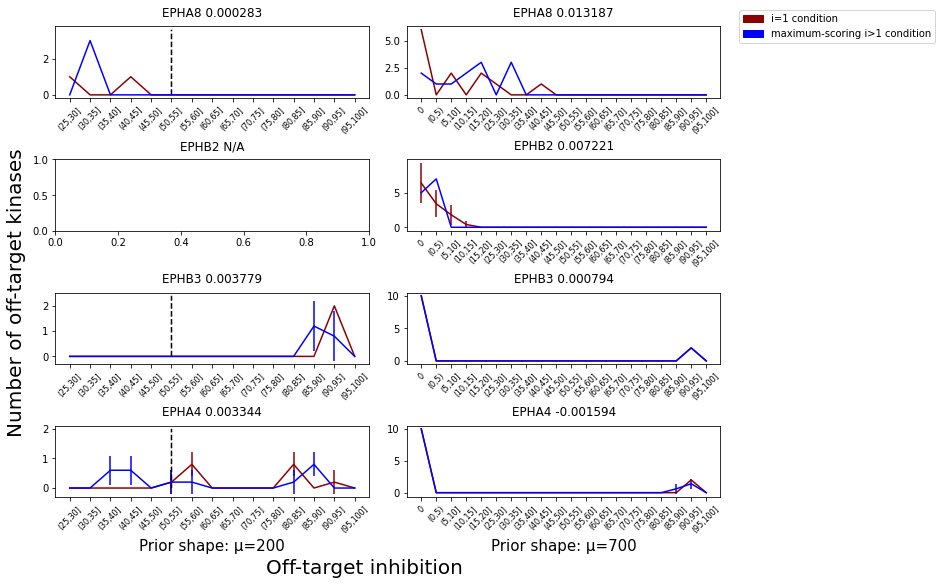

In [78]:
#Lets make a plot for each of these tracking the change in off-target activity and the number of off-target kinases
#We need to get all 5 groups of off-target values, and then average the 5 lists at each relative position
#Then we can plot the number of off-target kinases (+/- std for the 5 replicates) for the i=1 versus i>1 conditions

nrows = len(res)
ncols = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(10,8),constrained_layout=True)

fig.supxlabel('Off-target inhibition', fontsize=20)
fig.supylabel('Number of off-target kinases', fontsize=20)

i1_patch = mpatches.Patch(color='darkred', label='i=1 condition')
max_patch = mpatches.Patch(color='b', label='maximum-scoring i>1 condition')

fig.legend(handles=[i1_patch,max_patch],bbox_to_anchor=(1.3, 1))

axes[len(res)-1][0].set_xlabel('Prior shape: μ=200',fontsize=15)
axes[len(res)-1][1].set_xlabel('Prior shape: μ=700',fontsize=15)

for u in range(0, len(res)):
    
    print(u)
    
    k = res[u][1]
    score200 = res[u][2]
    score700 = res[u][3]
    
    if score200 != 'N/A':
        score200 = round(score200, 6)
        
    if score700 != 'N/A':
        score700 = round(score700, 6)
    
    index = final_kinases.index(k)
    
    off_target_200_i1_init = final_i1_200_off_target_values[index]
    off_target_700_i1_init = final_i1_700_off_target_values[index]
    
    off_target_200_max_init = final_200_off_target_values[index]
    off_target_700_max_init = final_700_off_target_values[index]
    
    ot_200_max = []
    ot_700_max = []
    i1_200 = []
    i1_700 = []
    
    for temp in off_target_200_max_init:
        vals = (temp[1:-1]).split(', ')
        vals = [float(x) for x in vals]
        ot_200_max.append(vals)
        
    for temp in off_target_700_max_init:
        vals = (temp[1:-1]).split(', ')
        vals = [float(x) for x in vals]
        ot_700_max.append(vals)
        
    for temp in off_target_200_i1_init:
        vals = (temp[1:-1]).split(', ')
        vals = [float(x) for x in vals]
        i1_200.append(vals)
        
    for temp in off_target_700_i1_init:
        vals = (temp[1:-1]).split(', ')
        vals = [float(x) for x in vals]
        i1_700.append(vals)
        
    #for each of the 5 technical replicates, construct bins for each
    #afterwards, we will average (an get the std) for each of the frequencies over the 5 technical replicates
    
    i1_200_binned = []
    
    for replicate in i1_200:
        bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
        for x in range(0, len(replicate)): #for every point in the set of sample noise (100 per measrument), add it to the distribution
            temp = int(replicate[x]/5)
            if temp < 20 and temp >= 0:
                bins[temp] += 1.0
            elif temp >= 20:
                bins[len(bins)-1] += 1.0
            else:
                bins[0] += 1.0
        i1_200_binned.append(bins)
        
    i1_700_binned = []
    
    for replicate in i1_700:
        bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
        for x in range(0, len(replicate)): #for every point in the set of sample noise (100 per measrument), add it to the distribution
            temp = int(replicate[x]/5)
            if temp < 20 and temp >= 0:
                bins[temp] += 1.0
            elif temp >= 20:
                bins[len(bins)-1] += 1.0
            else:
                bins[0] += 1.0
        i1_700_binned.append(bins)
        
        
    max_200_binned = []
    
    for replicate in ot_200_max:
        bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
        for x in range(0, len(replicate)): #for every point in the set of sample noise (100 per measrument), add it to the distribution
            temp = int(replicate[x]/5)
            if temp < 20 and temp >= 0:
                bins[temp] += 1.0
            elif temp >= 20:
                bins[len(bins)-1] += 1.0
            else:
                bins[0] += 1.0
        max_200_binned.append(bins)
        
    max_700_binned = []
    
    for replicate in ot_700_max:
        bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
        for x in range(0, len(replicate)): #for every point in the set of sample noise (100 per measrument), add it to the distribution
            temp = int(replicate[x]/5)
            if temp < 20 and temp >= 0:
                bins[temp] += 1.0
            elif temp >= 20:
                bins[len(bins)-1] += 1.0
            else:
                bins[0] += 1.0
        max_700_binned.append(bins)
        
    avg_i1_200=list(np.average(i1_200_binned, axis=0))
    std_i1_200=list(np.std(i1_200_binned, axis=0))
    
    avg_i1_700=list(np.average(i1_700_binned, axis=0))
    std_i1_700=list(np.std(i1_700_binned, axis=0))
    
    avg_max_200=list(np.average(max_200_binned, axis=0))
    std_max_200=list(np.std(max_200_binned, axis=0))
    
    avg_max_700=list(np.average(max_700_binned, axis=0))
    std_max_700=list(np.std(max_700_binned, axis=0))
    
    bin_max = ['0','(0,5)', '(5,10]', '(10,15]', '(15,20]', '(25,30]',
               '(30,35]', '(35,40]', '(40,45]', '(45,50]', '(50,55]',
               '(55,60]', '(60,65]', '(65,70]', '(70,75]', '(75,80]',
               '(80,85]', '(85,90]', '(90,95]', '(95,100]']
    
    #only plot from 20 upwards
    bin_max_200 = bin_max[5:]
    avg_i1_200 = avg_i1_200[5:]
    std_i1_200 = std_i1_200[5:]
    avg_max_200 = avg_max_200[5:]
    std_max_200 = std_max_200[5:]
    
    bin_max_700 = bin_max[:]
    avg_i1_700 = avg_i1_700[:]
    std_i1_700 = std_i1_700[:]
    avg_max_700 = avg_max_700[:]
    std_max_700 = std_max_700[:]
    
    ylim200_a = max(avg_i1_200)
    ylim200_b = max(avg_max_200)
    ylim_200 = max([ylim200_a,ylim200_b])
    
    if score200 != 'N/A':
    
        axes[u][0].errorbar(bin_max_200, avg_i1_200, yerr=std_i1_200,xerr=None, color='darkred')
        axes[u][0].errorbar(bin_max_200, avg_max_200, yerr=std_max_200,xerr=None, color='blue')
        axes[u][0].tick_params(axis='x', labelsize=8, rotation=45)
        
    axes[u][0].set_title(k+' '+str(score200), x=0.5, y=1.05)
        
    if score700 != 'N/A':
    
        axes[u][1].errorbar(bin_max_700, avg_i1_700, yerr=std_i1_700,xerr=None, color='darkred')
        axes[u][1].errorbar(bin_max_700, avg_max_700, yerr=std_max_700,xerr=None, color='blue')
        axes[u][1].tick_params(axis='x', labelsize=8, rotation=45)
        
    axes[u][1].set_title(k+' '+str(score700), x=0.5, y=1.05)
    
    #add a vertical line to represent where the on-target prior becomes innefectual in either
    print(ylim_200)
    t = ylim_200*1.2
    if t<2:
        t=2
    thresh1 = np.arange(0,t,0.001)
    xlim = [5]*len(thresh1)
    if score200 != 'N/A':
        axes[u][0].plot(xlim,thresh1,'k--')
    #axes[u][0].set_ylim((-0.2,int(ylim_200*1.2)))
    
    #axes[i][0].set_ylim(0, 10)
    #axes[i][1].set_ylim(0, 10)
        
    #now we need to 
    
fig.savefig("120821_PKIS_EPHS_JSD_200v1200_kinase-specific-plots.pdf", bbox_inches='tight',dpi=500)